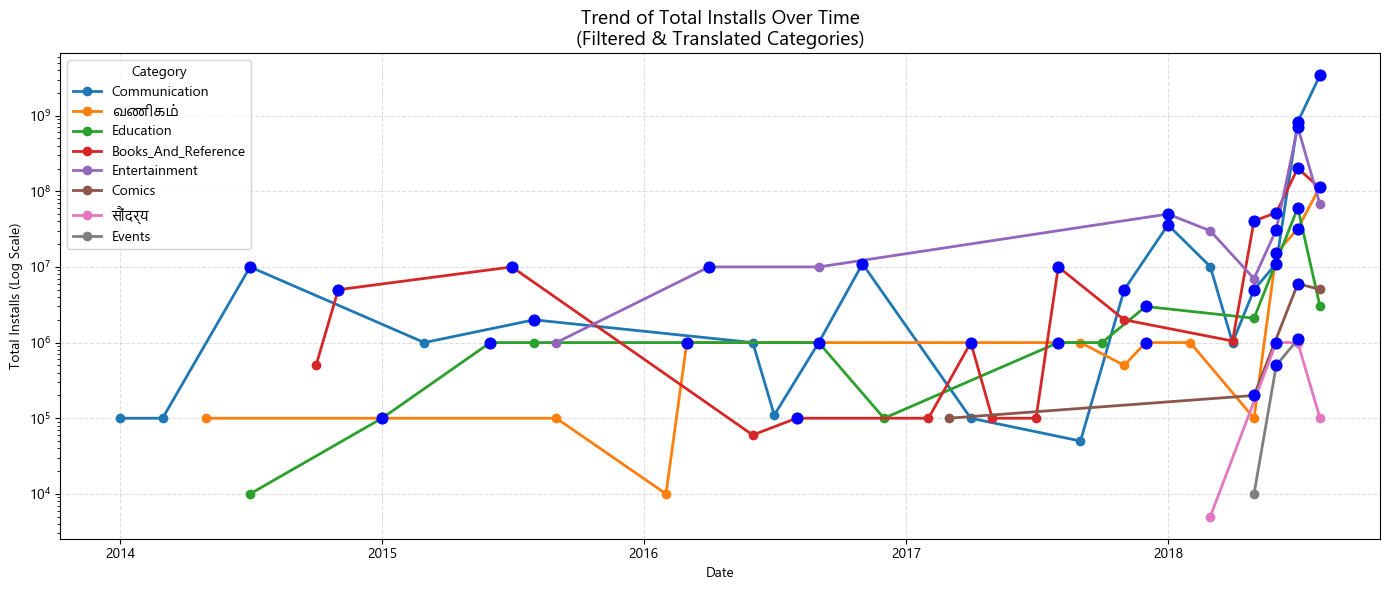

In [1]:

#import lib

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib

# fond with condition
matplotlib.rcParams['font.family'] = 'Nirmala UI' 

# time setting
IST = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(IST).time()

START_TIME = datetime.strptime("6:00", "%H:%M").time()
END_TIME = datetime.strptime("22:00", "%H:%M").time()

if not (START_TIME <= current_time <= END_TIME):
    print("Graph visible only between 6 PM IST and 25 PM IST")

else:

    # data loading
    FILE_PATH = "Play Store Data.csv"
    df = pd.read_csv(FILE_PATH)

    # data cleaning
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace('[+,]', '', regex=True)
    )
    df = df[df['Installs'].str.isnumeric()]
    df['Installs'] = df['Installs'].astype(int)

    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

    # Create Monthly Period
    df['Month'] = df['Last Updated'].dt.to_period('M').dt.to_timestamp()

    # filter with condition
    df = df[
        (df['Reviews'] > 500) &
        (~df['App'].str.lower().str.startswith(('x', 'y', 'z'))) &
        (~df['App'].str.contains('s', case=False)) &
        (df['Category'].str.startswith(('E', 'C', 'B')))
    ]
#translation
    CATEGORY_TRANSLATION = {
        'Beauty': 'सौंदर्य', # Hindi
        'Business': 'வணிகம்', # Tamil
        'Dating': 'Partnersuche' # German
    }

    df['Category_Display'] = (
        df['Category']
        .str.strip()
        .str.title()
        .replace(CATEGORY_TRANSLATION)
    )

    # monthly 
    monthly = (
        df.groupby(['Month', 'Category_Display'])['Installs']
        .sum()
        .reset_index()
        .sort_values('Month')
    )

    # month wise growth
    monthly['MoM_Growth'] = (
        monthly.groupby('Category_Display')['Installs']
        .pct_change()
    )

    
    # visualization
    plt.figure(figsize=(14, 6))

    for category in monthly['Category_Display'].unique():
        data = monthly[monthly['Category_Display'] == category]

        # Line Plot
        plt.plot(
            data['Month'],
            data['Installs'],
            marker='o',
            linewidth=2,
            label=category
        )

        # Highlight points where growth > 20%
        growth_points = data[data['MoM_Growth'] > 0.20]
        plt.scatter(
            growth_points['Month'],
            growth_points['Installs'],
            color='blue',
            s=60,
            zorder=5
        )
    plt.yscale('log')
    plt.xlabel("Date")
    plt.ylabel("Total Installs (Log Scale)")
    plt.title(
        "Trend of Total Installs Over Time\n"
        "(Filtered & Translated Categories)",
        fontsize=14
    )
    plt.legend(title="Category")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

